This document is number `1 of 5` documents I have written, based on the `LangChain Academy Deep Agents with LangGraph` course.

The course itself has repositories that it provides you with. If my documents are not useful to you, I suggest you check them out.

There are now several successful examples of very **capable** and **long-running** agents. They have given these agents the 
name `“Deep Agents”` because they believe that they are completely different from previous generations of agents. In 
this course, you will learn what makes them different and build your own Deep Agent.

In LangChain, a Deep Agent is built that is simple and configurable, allowing users to build long-running agents quickly and easily.

In this course, you will build a **Deep Research Agent** using Deep Agent. The course is divided into seven modules.

Each module includes a video lesson that introduces you to the key concepts, along with related workbooks.

---

This document walks you through creating a **ReAct** *(Reasoning and Acting)* AI agent using LangGraph’s prebuilt abstractions. The goal is to provide clear explanations and code examples so that even readers new to LangGraph can follow along and fully understand how it works.

LangGraph is a library for building `“graph-based”` AI workflows. The [prebuilt React agent](https://python.langchain.com/en/latest/modules/langchain/index.html#langgraph.prebuilt.create_react_agent) abstraction makes it easy to create an agent that reasons step-by-step (chain-of-thought) and calls external tools when needed. 

In this document, we’ll:

- Explain the ReAct framework and agent components

- Show how to define tools that the agent can call

- Build and invoke a ReAct agent with a calculator tool

- Examine how the agent’s graph, state, and messaging loop work

- Access and modify agent state inside tools

#### What is a ReAct Agent?
A ReAct agent combines **chain-of-thought reasoning** **(CoT)** with the ability to call external tools during the reasoning process. It operates in a loop:

- **LLM Thinks:** The language model (LLM) reviews its system prompt, the conversation history, and information about available tools.

- **Decide to Act:** The LLM decides if a tool is needed to answer the question or help reasoning. If so, it selects a tool and provides the arguments for that tool in a special `“tool call.”`

- **Call Tools:** The agent framework detects the tool call, executes the corresponding tool (e.g., a calculator, search engine, or any custom function), and returns the result.

- **Observe and Continue:** The LLM sees the tool’s output (the observation), incorporates it into its reasoning, and either calls another tool or generates a final answer.

- **Loop Ends:** When the LLM no longer needs any more tools, it produces a final response to the user.

The LangGraph `create_react_agent` function automates this loop. You provide an LLM (via LangChain), one or more tools (functions decorated with `@tool`), and an optional system prompt. Under the hood, LangGraph builds a state graph with nodes for the LLM and tool executions, handling the message flow, state updates, and stopping conditions for you.

#### Key Features of LangGraph’s Prebuilt Agent

The `create_react_agent` abstraction offers many advanced features (we won’t use all of them in this simple example, but they’re worth knowing):

- **Memory:** You can enable *short-term* or *long-term* memory to make the agent’s behavior stateful across turns or sessions.

- **Human-in-the-loop:** The agent can pause for human feedback or approval between steps.

- **Streaming:** Support for streaming tokens and tool outputs in real time.

- **Traces:** Integrates with LangSmith to trace and debug the agent’s execution.

- **Structured Output:** Define a schema for the final response, and LangGraph can enforce and output structured `JSON`.

In this document, we’ll use the “simple” agent format without hooks or structured outputs, just to focus on the core mechanism. We will, however, demonstrate how to manage custom state and look at how tool calls work in practice.


#### Defining a Tool
Agents become truly powerful when they can call tools—special functions that do tasks like *calculations*, *web searches*, *database queries*, etc. For this example, we’ll create a simple **calculator tool**.

Using LangChain’s `@tool` decorator, we define any Python function as a callable tool. Here’s a basic **two-input** calculator:

In [1]:
from typing import Literal, Union
from langchain_core.tools import tool

@tool
def calculator(
    operation: Literal["add", "subtract", "multiply", "divide"],
    a: Union[int, float],
    b: Union[int, float],
) -> Union[int, float]:
    """A simple calculator that adds, subtracts, multiplies, or divides two numbers."""
    # Handle edge cases
    if operation == "divide" and b == 0:
        return {"error": "Division by zero is not allowed."}

    # Perform the calculation
    if operation == "add":
        return a + b
    elif operation == "subtract":
        return a - b
    elif operation == "multiply":
        return a * b
    elif operation == "divide":
        return a / b
    else:
        return "unknown operation"


**Explanation:**

We use a type `Literal[...]` for the operation argument so the agent knows the tool takes one of these four operations.

The function returns the calculation result (or an error message if dividing by zero).

The returned value (even a dict with an error) will become the `“tool output”` that the agent can pass back to the LLM.


#### Building the Agent
With the tool defined, we create the agent by calling `create_react_agent`. 
We need to provide:

- The LLM model to use (via LangChain).

- A list of tools (our calculator, and we could add more later).

- A system prompt that explains the agent’s role or instructions.

- Optionally, a state schema if we want to track custom state (*we’ll do that later*).

In [ ]:
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent

# 1) Define a system prompt for the agent
SYSTEM_PROMPT = (
    "You are a helpful arithmetic assistant who is an expert at using a calculator."
    )   

# 2) Initialize the LLM (ensure OPENAI_API_KEY is set)
model = init_chat_model(model="openai:gpt-4o-mini", api_key="sk-proj-***", temperature=0.0)

# 3) Create the agent with the model and the calculator tool
agent = create_react_agent(
    model=model,
    tools=[calculator],
    prompt=SYSTEM_PROMPT,
    # state_schema defaults to AgentState
).with_config({"recursion_limit": 20})


**Key points:**

`init_chat_model` loads a chat model (here *gpt-4o-mini*). You can also use `ChatOpenAI` directly. The `temperature=0.0` makes it deterministic.
``create_react_agent`` returns a compiled state graph (the agent). We pass our single calculator tool in a list.
We set `recursion_limit` to 20 to prevent the agent from looping forever calling tools. This is the max number of **LLM→tool** steps.

#### Visualize the agent graph

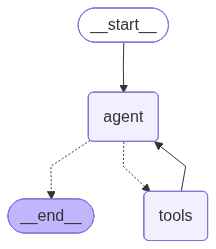

In [3]:
from IPython.display import Image, display

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

Invoking the Agent
To use the agent, we call `agent.invoke(...)` with an input message. The message format is a list of messages (like in LangChain). 
Here’s an example:

In [4]:
from langchain_core.messages import HumanMessage ,ToolMessage

# Local helper to pretty-print message history
def FormatMessages(messages):
    for message in messages:
        if isinstance(message, HumanMessage):
            print(f"🧑 Human: {message.content}")
        elif hasattr(message, "tool_calls") and getattr(message, "tool_calls"):
            print("📝 AI:")
            for call in message.tool_calls:
                name = call.get("name")
                args = call.get("args")
                print(f"    🔧 Tool Call: {name} ")
                print(f"        Args: {args}")
        elif isinstance(message, ToolMessage):
            print(f"🛠️ Tool Output: {message.content}")
        else:
            content = getattr(message, "content", "")
            if content:
                print(f"📝 AI: {content}")

result1 = agent.invoke(
    {
        "messages": [
            {"role": "user", "content": "What is 3.1 * 4.2?"}
        ]
    }
)

FormatMessages(result1["messages"])

🧑 Human: What is 3.1 * 4.2?
📝 AI:
    🔧 Tool Call: calculator 
        Args: {'operation': 'multiply', 'a': 3.1, 'b': 4.2}
🛠️ Tool Output: 13.020000000000001
📝 AI: The result of \( 3.1 \times 4.2 \) is approximately \( 13.02 \).


This returns a dictionary representing the final state after the agent finishes. It includes a `"messages"` key, which is the full conversation history (including the assistant’s steps). We used a helper to print the messages:

**User asks:** *“What is 3.1 * 4.2?”*

**Agent (AI) decides** to use the calculator tool with `operation="multiply"`, *a=3.1*, *b=4.2*. Notice this appears as an AIMessage with a `🔧 Tool Call`.

**ToolNode executes:** It runs our calculator function, which returns *13.02*.

`Tool output` (13.02) is added to the conversation as a `ToolMessage` (shown as 🛠️ Tool Output).

Agent (AI) processes the tool output and gives the final answer: *“3.1 multiplied by 4.2 is 13.02.”*

The loop stopped because the agent didn’t request any more tools after getting the result (*enough information to answer the user*).

You could log this trace with [LangSmith](https://langchain.com/langsmith) for debugging. 
The important thing is: the agent alternates between the LLM deciding on an action and executing tools until done.

How It Works: Graph, State, and Messages
- Graph: create_react_agent compiles a LangGraph graph with an LLM node and a Tool node.
- State: Defaults to AgentState, primarily a list of messages plus a remaining_steps counter.

- Messages:
    - LLM proposes tool calls via AIMessage(tool_calls=[...])
    - Tool node executes registered tools and returns ToolMessage with tool_call_id
    - LLM reads observations and decides next action or final answer

Internals you’ll observe in traces:

- Tool descriptions included in model call metadata
- Matching tool_call_id across AI/tool messages

#### Agent State and Messages
LangGraph agents maintain a state, which is a typed dictionary tracking data throughout the execution. By default, the prebuilt agent uses `AgentState`, which looks like this:

In [5]:
from typing import Sequence, TypedDict, NotRequired, Annotated
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages  # a reducer

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    remaining_steps: NotRequired[int]


The messages list holds all `BaseMessage` objects (human, AI, or tool messages). The special `add_messages` reducer appends new messages to this list automatically.

`remaining_steps` (optional) tracks how many steps the graph is allowed to run before hitting the recursion limit.


In [6]:
from langchain_core.messages import messages_to_dict
import json

print(json.dumps(messages_to_dict(result1["messages"]), indent=2))


[
  {
    "type": "human",
    "data": {
      "content": "What is 3.1 * 4.2?",
      "additional_kwargs": {},
      "response_metadata": {},
      "type": "human",
      "name": null,
      "id": "25f210a3-ed3b-4dbf-856d-6d606c09d9f6",
      "example": false
    }
  },
  {
    "type": "ai",
    "data": {
      "content": "",
      "additional_kwargs": {
        "tool_calls": [
          {
            "id": "call_ohicPHQiXrdCJSHmBJC7yB3L",
            "function": {
              "arguments": "{\"operation\":\"multiply\",\"a\":3.1,\"b\":4.2}",
              "name": "calculator"
            },
            "type": "function"
          }
        ],
        "refusal": null
      },
      "response_metadata": {
        "token_usage": {
          "completion_tokens": 26,
          "prompt_tokens": 105,
          "total_tokens": 131,
          "completion_tokens_details": {
            "accepted_prediction_tokens": 0,
            "audio_tokens": 0,
            "reasoning_tokens": 0,
          

This outputs the full sequence of messages the agent exchanged, which can be helpful for debugging or understanding exactly what happened each step.

#### Access and Modify State From Within Tools
Sometimes you need tools to **both** return an *observation* and *update extra state* (e.g., an operation log). You can extend the default state and safely update it.

#### Extending State: Custom Reducers
One powerful feature of LangGraph is you can extend the agent’s state with your own fields. For example, maybe we want the agent to remember a history of operations it performed. We can define a custom state schema by subclassing `AgentState`.

First, we write a reducer function for merging lists safely, Then we create a new state type:

In [7]:
from typing import Annotated
from langgraph.prebuilt.chat_agent_executor import AgentState


def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists (treat None as empty list)."""
    left = left or []
    right = right or []
    return left + right

class CalcState(AgentState):
    """Graph State with an operation log."""
    ops: Annotated[list[str], reduce_list]

Here, `ops` is a list of strings, and we use `reduce_list` to tell LangGraph how to combine values if multiple updates happen. This field will track what operations were done.

#### Inject state and tool_call_id into the tool
Use `InjectedState` to prevent the LLM from seeing/constructing the state argument. Use `InjectedToolCallId` to produce a proper `ToolMessage` that matches the call.

When a tool needs to **read** or **update** the agent state, we use special annotations. The LLM itself never sees the full state, so the state object in a tool function must come from an injection by the framework.

We modify our calculator tool to accept the state (and the `tool_call_id`) as injected arguments:

In [8]:
from langgraph.prebuilt import InjectedState
from langchain_core.tools import InjectedToolCallId
from langgraph.types import Command
from langchain_core.messages import ToolMessage

@tool
def calculator_wstate(
    operation: Literal["add", "subtract", "multiply", "divide"],
    a: Union[int, float],
    b: Union[int, float],
    state: Annotated[CalcState, InjectedState],        # injected by LangGraph
    tool_call_id: Annotated[str, InjectedToolCallId],  # injected by LangGraph
) -> Command:
    """Calculator tool that updates state with the operation."""
    # Perform calculation
    if operation == "divide" and b == 0:
        result = "error: division by zero"
    elif operation == "add":
        result = a + b
    elif operation == "subtract":
        result = a - b
    elif operation == "multiply":
        result = a * b
    elif operation == "divide":
        result = a / b
    else:
        result = "unknown operation"
    
    # Prepare an entry for the operation history
    ops_entry = f"({operation}, {a}, {b})"
    
    # Return a Command that updates state
    return Command(
        update={
            "ops": [ops_entry],  # adds to the list of ops
            "messages": [
                ToolMessage(str(result), tool_call_id=tool_call_id)
            ],
        }
    )


**How this works:**

The state parameter is annotated with `InjectedState`, so LangGraph uses the current graph state (a `CalcState` object) when calling this function. The LLM never sees the state content during thought.

`tool_call_id` is similarly injected to link the `ToolMessage` to the original call.

Instead of returning the raw result, the tool returns a `Command` with an update dictionary. This tells LangGraph to:
- Append `ops_entry` to the `ops` list in state.
- Append a `ToolMessage` with the result content to messages in state.

The messages key in update with a `ToolMessage` is how we feed the tool’s output back to the LLM. It works like our previous example, but now we manage state updates explicitly.

#### Create an agent with the new state schema

In [ ]:
SYSTEM_PROMPT = "You are a helpful arithmetic assistant who is an expert at using a calculator."

model = init_chat_model(model="openai:gpt-4o-mini", api_key="sk-proj-***", temperature=0.0)
tools = [calculator_wstate]

agent = create_react_agent(
    model,
    tools,
    prompt=SYSTEM_PROMPT,
    state_schema=CalcState,     # custom state
).with_config({"recursion_limit": 20})


#### Run and inspect state

In [ ]:
result2 = agent.invoke(
    {
        "messages": [
            {"role": "user", "content": "What is 3.1 * 4.2?"}
        ],
    }
)

# we can inspect the ops list:
print(result2["ops"])  # access the custom state field

['(multiply, 3.1, 4.2)']


#### Parallel tool calls Example
The tool node can execute multiple tool calls in parallel when the LLM proposes them in a **single step**. For example:

In [16]:
result3 = agent.invoke({
    "messages": [{"role": "user", "content": "What is 3.1 * 4.2 + 5.5 * 6.5?"}]
})
print(FormatMessages(result3["messages"]))

🧑 Human: What is 3.1 * 4.2 + 5.5 * 6.5?
📝 AI:
    🔧 Tool Call: calculator_wstate 
        Args: {'operation': 'multiply', 'a': 3.1, 'b': 4.2}
    🔧 Tool Call: calculator_wstate 
        Args: {'operation': 'multiply', 'a': 5.5, 'b': 6.5}
🛠️ Tool Output: 13.020000000000001
🛠️ Tool Output: 35.75
📝 AI:
    🔧 Tool Call: calculator_wstate 
        Args: {'operation': 'add', 'a': 13.020000000000001, 'b': 35.75}
🛠️ Tool Output: 48.77
📝 AI: The result of \( 3.1 \times 4.2 + 5.5 \times 6.5 \) is \( 48.77 \).
None


**What happens here:**

The LLM emits two tool calls at once: one to multiply 3.1 by 4.2, and another to multiply 5.5 by 6.5. The agent framework runs them in parallel.

There are two 🛠️ Tool Outputs (one for each multiplication).

The LLM then sees both results and issues a final tool call to add them together.

After that tool call, it returns the final answer.

The history (ops) is updated with all operations in order:

`["(multiply, 3.1, 4.2)", "(multiply, 5.5, 6.5)", "(add, 13.02, 35.75)"]`

This demonstrates how the agent can chain and combine tool usage to solve more complex tasks.